In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [3]:
dasgupta = pd.read_csv('vou/vou/inputs/dasgupta2016_OD_rates.csv')

In [4]:
dasgupta['dose_mid'] = np.ceil((dasgupta.dose_lower + dasgupta.dose_upper) / 2)
dasgupta.dose_mid[14] = 650 # per paper
dasgupta['rate_per_py'] = dasgupta.rate_per_10k_py / 10_000
dasgupta['rate_per_day'] = dasgupta.rate_per_py / 365.25

# Per Dunn et al 2010, about 1 in every 8.5 overdoses is fatal. Since these rates are for overdose deaths, 
# we need to adjust them to get overdose rates. This is a very crude method. It does not account for the
# possibility that overdoses with higher doses are more likely to be fatal. But it's enough for now.
dasgupta['OD_rate_per_day'] = dasgupta.rate_per_day * 8.5

# Since these doses all have very low OD probabilities, we can't fit a logistic function reliably. 
# Here we manually add a much higher dose that is in the ballpark of what is qualitatively considered
# a certainly lethal dose.
deadly_dose = {
    'dose_lower': 2000, 
    'dose_upper': 2000, 
    'rate_per_10k_py': None, 
    'dose_mid': 2000,
    'rate_per_py': None, 
    'rate_per_day': None, 
    'OD_rate_per_day': 1
}
dasgupta = dasgupta.append(deadly_dose, ignore_index=True)

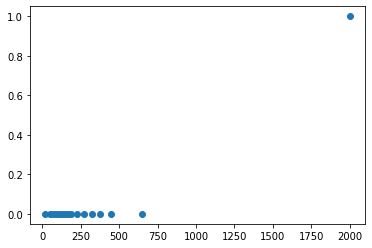

In [5]:
plt.scatter(dasgupta.dose_mid, dasgupta.OD_rate_per_day)

In [6]:
def logistic(x, x0, k):
    """
    Define the logistic model function.

    Per scipy's curve_fit, must take the independent variable as the first
    argument and the parameters to fit as separate remaining arguments.

    L is the curve's maximum value
    x0 is the x value at the sigmoid's midpoint
    k is the logistic growth rate or steepness of the curve
    b is the intercept
    """
    L = 1
    b = 0
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return y

In [7]:
def set_starting_guess(xdata: pd.Series, ydata: pd.Series, k: float = 1):
    """
    Uses the series of x data to be modeled to set the initial guesses for the
    parameters in the order they are specified in the logistic function. 

    Starting guesses:
    L is the maximum of the x values
    x0 is the median of the x values
    k is defined in the parameters (default of 1)
    b is the minimum of the y values
    """
    # L = np.max(ydata)
    x0 = np.median(xdata)
    k = k
    # b = np.min(ydata)
    return [x0, k]


p0 = [1000, .0001]


In [8]:
# Set bounds for the parameters to be optimized.
# L upper bound is 1 since y is a probability.

# Bounds:
# L: 0, 1
# x0: 0, infinity
# k: 0, infinity
# b: 0, infinity

bounds = ([0.999, 0, 0, 0], [1, np.inf, np.inf, np.inf])


In [9]:
logistic_coefficients, logistic_cov_matrix = curve_fit(
    f=logistic, 
    xdata=dasgupta.dose_mid, 
    ydata=dasgupta.OD_rate_per_day, 
    p0=p0, 
    # bounds=bounds, 
    method='dogbox',
)

In [12]:
logistic_y_pred = logistic(dasgupta.dose_mid, *logistic_coefficients)

Can't find a good fit with a logistic model. Let's try linear.

In [60]:
def polynomial(x, B0, B1, B2, B3):
    """
    Define the linear model function.

    B0 is the intercept
    B1 is the coefficient for the x term
    B2 is the cofficient for x-squared term
    B3 is the coefficient for third order polynomial
    """
    y = B0 + (B1 * x) + (B2 * x**2) + (B3 * x**3)
    return y

In [61]:
poly_coefficients, poly_cov_matrix = curve_fit(
    f=polynomial, 
    xdata=dasgupta.dose_mid, 
    ydata=dasgupta.OD_rate_per_day, 
)

In [62]:
polynomial_pred = polynomial(dasgupta.dose_mid, *coefficients)

Polynomial term doesn't seem to be doing much, let's try a simple linear model.

In [63]:
def zero_intercept_linear(x, slope):
    """
    Zero-intercept linear function
    """
    y = slope * x
    return y

In [100]:
lin_coefficients, lin_cov_matrix = curve_fit(
    f=zero_intercept_linear, 
    xdata=dasgupta.dose_mid[:-2], 
    ydata=dasgupta.OD_rate_per_day[:-2], 
)

In [102]:
linear_pred = zero_intercept_linear(dasgupta.dose_mid, *lin_coefficients)
linear_pred

0     0.000005
1     0.000014
2     0.000019
3     0.000025
4     0.000030
5     0.000035
6     0.000041
7     0.000046
8     0.000052
9     0.000061
10    0.000075
11    0.000089
12    0.000102
13    0.000123
14    0.000177
15    0.000546
Name: dose_mid, dtype: float64

In [15]:
def plot(function):
    # Generate an array to use for the prediction line
    x_line = np.arange(min(dasgupta.dose_mid), max(dasgupta.dose_mid))
    if function == 'linear':
        y_line = zero_intercept_linear(x_line, *coefficients)
    elif function == 'polynomial':
        y_line = polynomial(x_line, *coefficients)
    elif function == 'logistic':
        y_line = logistic(x_line, *logistic_coefficients)
    # Plot
    plt.scatter(dasgupta.dose_mid, dasgupta.OD_rate_per_day)
    plt.plot(x_line, y_line, '--', color='red')
    plt.xlabel('Dose (MME)')
    plt.ylabel('OD Probability')


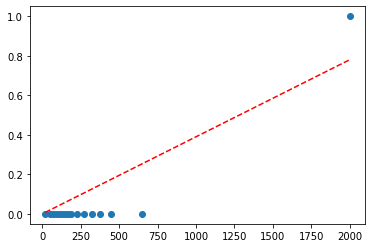

In [70]:
plot('linear')

In [72]:
plot('polynomial')

TypeError: polynomial() missing 3 required positional arguments: 'B1', 'B2', and 'B3'

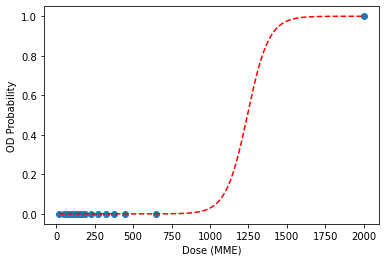

In [16]:
plot('logistic')

In [ ]:
# Logistic coefficients:
# L = 1
# b = 0
# x0 = 1243.6936832876
# k = 0.0143710866
# y = L / (1 + np.exp(-k * (x - x0))) + b